#Key Factors in Global Freelancer Ratings

##This kernel is based on and forked from an insightful original work by [Author's Name].

In [27]:

import kagglehub
urvishahir_global_freelancers_raw_dataset_path = kagglehub.dataset_download('urvishahir/global-freelancers-raw-dataset')

print('Data source import complete.')


Data source import complete.


## Table of Contents

- [Introduction](#Introduction)
- [Data Loading and Inspection](#Data-Loading-and-Inspection)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Predictor Model](#Predictor-Model)
- [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Introduction

Freelancers are redefining the modern workplace and breaking the traditional 9-to-5 mold. This notebook embarks on an exploration of global freelancer data with the aim to uncover key trends and insights that might influence client satisfaction and overall performance. With a blend of descriptive statistics and predictive modeling, we hope to provide a comprehensive view of the factors that contribute to success in this diverse talent pool.

In [28]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting
%matplotlib inline

# Set plot style
sns.set(style='whitegrid', palette='Set2')

## Data Loading and Inspection

We start by loading the dataset. The data file is a CSV located in the directory `/kaggle/input/global-freelancers-raw-dataset/` and includes information on freelancer IDs, personal details, skills, experience, and ratings.

In [29]:
# Load the dataset
data_path = '/content/global_freelancers_raw.csv'
df = pd.read_csv(data_path, delimiter=',', encoding='ascii')

# Display the first few rows
print('DataFrame shape:', df.shape)
df.head()

DataFrame shape: (1000, 12)


,freelancer_ID,name,gender,age,country,language,primary_skill,years_of_experience,hourly_rate (USD),rating,is_active,client_satisfaction
0,FL250001,Ms. Nicole Kidd,f,52.0,Italy,Italian,Blockchain Development,11.0,100,NaN,0,NaN
1,FL250002,Vanessa Garcia,FEMALE,52.0,Australia,English,Mobile Apps,34.0,USD 100,3.3,1,84%
2,FL250003,Juan Nelson,male,53.0,Germany,German,Graphic Design,31.0,50,0.0,N,71%
3,FL250004,Amanda Spencer,F,38.0,Australia,English,Web Development,4.0,$40,1.5,N,90%
4,FL250005,Lynn Curtis DDS,female,53.0,Germany,German,Web Development,27.0,30,4.8,0,83%


## Data Cleaning and Preprocessing

Before diving into the visualizations and modeling, it is important to address potential data quality issues. One such issue pertains to the `hourly_rate (USD)` column, which is stored as a string. We assume that this column might include formatting characters such as `'$'` or commas. Here we will strip any extraneous non-numeric characters and convert the column to a numeric type.

After that, we verify that numeric columns such as `age`, `years_of_experience`, and `rating` are of the correct type. Since our dataset does not include any date columns, no date parsing is necessary.

In [30]:
# Convert the 'hourly_rate (USD)' from string to numeric
def clean_hourly_rate(rate):
    # Remove any characters except numbers and decimal points (example: '$', ',', 'USD ')
    try:
      rate = str(rate).replace('$', '').replace(',', '').replace('USD ', '').strip()
      return float(rate)
    except Exception as e:
      # Log the error for potential debugging
      print(f'Error converting rate {rate}:', e)
      return np.nan

df['hourly_rate_numeric'] = df['hourly_rate (USD)'].apply(clean_hourly_rate)

# Convert certain columns to numeric if necessary
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['years_of_experience'] = pd.to_numeric(df['years_of_experience'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Display info to verify types
df.info()

# It is also helpful to check for any missing values
print('\nMissing values in each column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   freelancer_ID        1000 non-null   object 
 1   name                 1000 non-null   object 
 2   gender               1000 non-null   object 
 3   age                  970 non-null    float64
 4   country              1000 non-null   object 
 5   language             1000 non-null   object 
 6   primary_skill        1000 non-null   object 
 7   years_of_experience  949 non-null    float64
 8   hourly_rate (USD)    906 non-null    object 
 9   rating               899 non-null    float64
 10  is_active            911 non-null    object 
 11  client_satisfaction  824 non-null    object 
 12  hourly_rate_numeric  906 non-null    float64
dtypes: float64(4), object(9)
memory usage: 101.7+ KB

Missing values in each column:
freelancer_ID            0
name                     0
gend

In [31]:
# Convert to lowercase, then map and capitalize
df['gender'] = df['gender'].astype(str).str.lower().replace({'f': 'female', 'm': 'male', 'nan': np.nan})

# 2. Fill any remaining NaN values with a specific value
df['gender'].fillna('Unknown', inplace=True)

df['gender'] = df['gender'].str.capitalize() # To get 'Female' and 'Male'

df['gender'] = df['gender'].astype('category')

# Check unique values after cleaning
print("Unique values in 'gender' after cleaning:")
print(df['gender'].unique())

# Check value counts
print("\nValue counts in 'gender':")
print(df['gender'].value_counts(dropna=False)) # dropna=False to see if there are 'NaN' or 'nan' as strings
print("Data type of 'gender':", df['gender'].dtype)

Unique values in 'gender' after cleaning:
['Female', 'Male']
Categories (2, object): ['Female', 'Male']

Value counts in 'gender':
gender
Male      510
Female    490
Name: count, dtype: int64
Data type of 'gender': category


In [32]:
# First, view current unique values to detect any other inconsistencies
print("Unique values in 'is_active' BEFORE cleaning:")
print(df['is_active'].unique())
print("\nValue counts in 'is_active' BEFORE cleaning:")
print(df['is_active'].value_counts(dropna=False))

# Convert to string and lowercase to standardize
df['is_active'] = df['is_active'].astype(str).str.lower()

# Map values to 'Yes' or 'No'
df['is_active'] = df['is_active'].replace({
    'yes': 'Yes',
    'y': 'Yes',
    '1': 'Yes',
    'true': 'Yes',
    'no': 'No',
    'n': 'No',
    '0': 'No',
    'false': 'No',
    'nan': np.nan
})

df['is_active'].fillna('Unknown', inplace=True)

# Convert to 'category' type for efficiency
df['is_active'] = df['is_active'].astype('category')

print("\nUnique values in 'is_active' AFTER cleaning:")
print(df['is_active'].unique())
print("\nValue counts in 'is_active' AFTER cleaning:")
print(df['is_active'].value_counts(dropna=False))
print("\nData type of 'is_active' after cleaning:")
print(df['is_active'].dtype)

Unique values in 'is_active' BEFORE cleaning:
['0' '1' 'N' 'False' 'True' 'yes' 'Y' nan 'no']

Value counts in 'is_active' BEFORE cleaning:
is_active
1        190
0        182
N         98
False     97
Y         94
NaN       89
no        88
yes       85
True      77
Name: count, dtype: int64

Unique values in 'is_active' AFTER cleaning:
['No', 'Yes', 'Unknown']
Categories (3, object): ['No', 'Unknown', 'Yes']

Value counts in 'is_active' AFTER cleaning:
is_active
No         465
Yes        446
Unknown     89
Name: count, dtype: int64

Data type of 'is_active' after cleaning:
category


In [33]:
# Cleaning function for 'client_satisfaction'
def clean_client_satisfaction(satisfaction_value):
    if pd.isna(satisfaction_value): # Handles NaN or None
        return np.nan

    s_value = str(satisfaction_value).strip() # Convert to string and remove spaces

    # Remove the '%' sign
    s_value = s_value.replace('%', '')

    # Attempt to convert to float
    try:
        return float(s_value)
    except ValueError:
        # If the cleaned string is not a number (e.g., "N/A", "", etc.)
        return np.nan

# Apply the function to the column
df['client_satisfaction'] = df['client_satisfaction'].apply(clean_client_satisfaction)

print("\nStatus of 'client_satisfaction' column:")
print(df[['client_satisfaction']].head(15))
print("Data type after cleaning:", df['client_satisfaction'].dtype)
print("Null values after cleaning:", df['client_satisfaction'].isnull().sum())
print("-" * 50)



Status of 'client_satisfaction' column:
    client_satisfaction
0                   NaN
1                  84.0
2                  71.0
3                  90.0
4                  83.0
5                   NaN
6                  94.0
7                  94.0
8                  76.0
9                   NaN
10                 77.0
11                 86.0
12                 86.0
13                 93.0
14                 70.0
Data type after cleaning: float64
Null values after cleaning: 176
--------------------------------------------------


In [34]:
# Print value counts for 'country' column
print("Value counts for 'country' column:")
print(df['country'].value_counts())

# Print number of unique countries
print("\nNumber of unique countries:", df['country'].nunique())

# Convert 'country' column to 'category' dtype for efficiency
df['country'] = df['country'].astype('category')

# Confirm 'country' dtype after conversion
print("\nData type of 'country' after category conversion:")
print(df['country'].dtype)

Value counts for 'country' column:
country
South Korea       68
Canada            65
Germany           52
Netherlands       51
Australia         51
Mexico            50
United Kingdom    50
United States     49
China             49
Russia            47
Argentina         47
Indonesia         46
Spain             45
India             45
Turkey            45
South Africa      44
France            44
Italy             42
Egypt             42
Japan             37
Brazil            31
Name: count, dtype: int64

Number of unique countries: 21

Data type of 'country' after category conversion:
category


In [35]:
# Print value counts for 'language' column
print("Value counts in 'language':")
print(df['language'].value_counts())

# Print number of unique languages
print("\nNumber of unique languages:", df['language'].nunique())

# Convert 'language' column to 'category' dtype for efficiency
df['language'] = df['language'].astype('category')

# Confirm 'language' dtype after conversion
print("\nData type of 'language' after converting to category:")
print(df['language'].dtype)

Value counts in 'language':
language
English       215
Spanish       142
Korean         68
German         52
Dutch          51
Mandarin       49
Russian        47
Indonesian     46
Turkish        45
Hindi          45
Afrikaans      44
French         44
Arabic         42
Italian        42
Japanese       37
Portuguese     31
Name: count, dtype: int64

Number of unique languages: 16

Data type of 'language' after converting to category:
category


In [36]:
# Value counts in primary_skill
print("Value counts in 'primary_skill':")
print(df['primary_skill'].value_counts(dropna=False))

print("\nNumber of unique skills:", df['primary_skill'].nunique())

Value counts in 'primary_skill':
primary_skill
DevOps                    112
UI/UX Design              109
Blockchain Development    105
Web Development           104
Mobile Apps               102
AI                        100
Data Analysis              96
Graphic Design             93
Machine Learning           93
Cybersecurity              86
Name: count, dtype: int64

Number of unique skills: 10


In [37]:
# Descriptive statistics
print('Descriptive Statistics:')
print(df.describe())

Descriptive Statistics:
              age  years_of_experience      rating  client_satisfaction  \
count  970.000000           949.000000  899.000000           824.000000   
mean    40.509278            11.340358    2.512570            79.269417   
std     11.942605             9.680610    1.546599            11.495162   
min     20.000000             0.000000    0.000000            60.000000   
25%     31.000000             3.000000    1.400000            69.750000   
50%     41.000000             9.000000    2.600000            79.000000   
75%     51.000000            17.000000    3.800000            89.000000   
max     60.000000            41.000000    5.000000           100.000000   

       hourly_rate_numeric  
count           906.000000  
mean             52.461369  
std              27.323742  
min              20.000000  
25%              30.000000  
50%              40.000000  
75%              75.000000  
max             100.000000  


In [38]:
# Get a summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   freelancer_ID        1000 non-null   object  
 1   name                 1000 non-null   object  
 2   gender               1000 non-null   category
 3   age                  970 non-null    float64 
 4   country              1000 non-null   category
 5   language             1000 non-null   category
 6   primary_skill        1000 non-null   object  
 7   years_of_experience  949 non-null    float64 
 8   hourly_rate (USD)    906 non-null    object  
 9   rating               899 non-null    float64 
 10  is_active            1000 non-null   category
 11  client_satisfaction  824 non-null    float64 
 12  hourly_rate_numeric  906 non-null    float64 
dtypes: category(4), float64(5), object(4)
memory usage: 76.0+ KB


## Exploratory Data Analysis

In this section we will generate a variety of plots to get a deeper understanding of the dataset. We start with descriptive statistics and visual charts. We create histograms for numerical distributions, count plots for categorical breakdowns, pair plots to observe relationships between numeric features, and a correlation heatmap (provided there are four or more numeric columns) to illustrate linear associations.

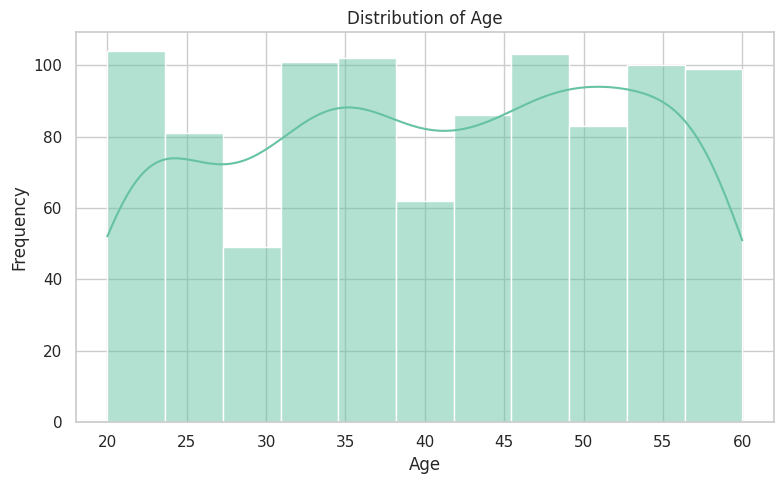

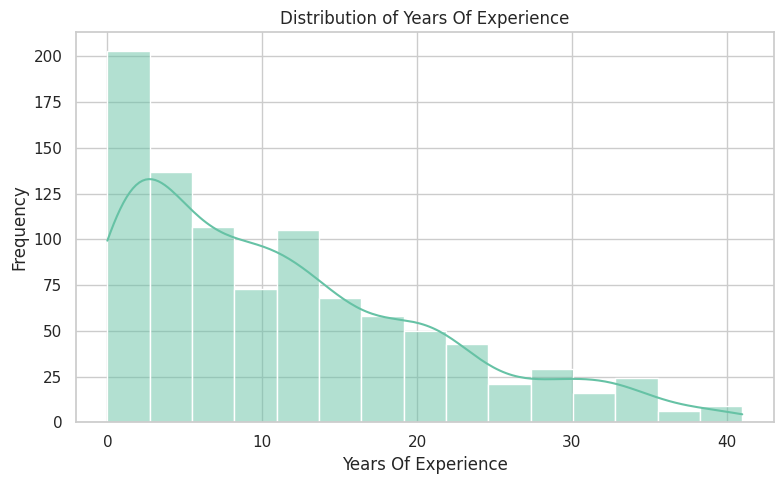

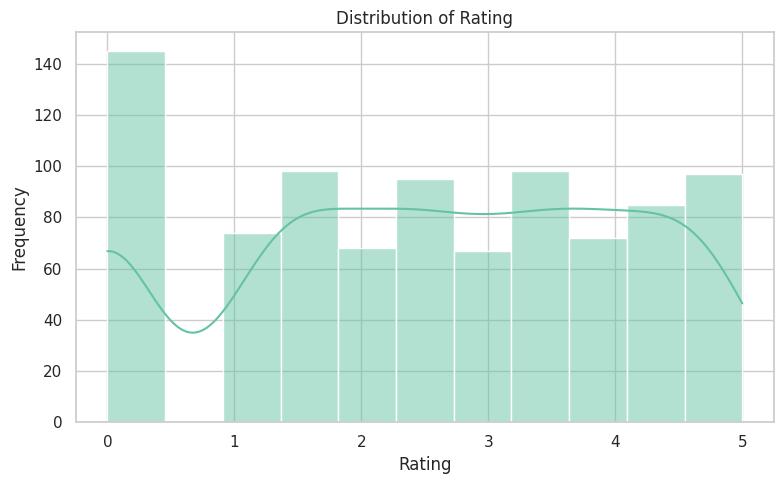

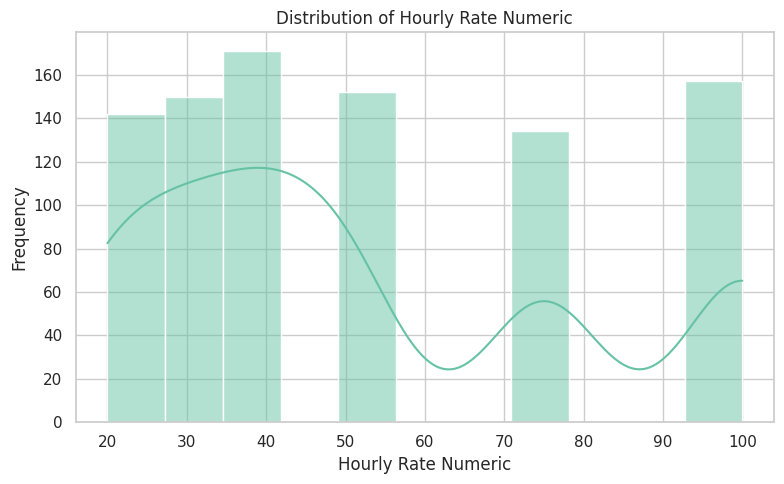

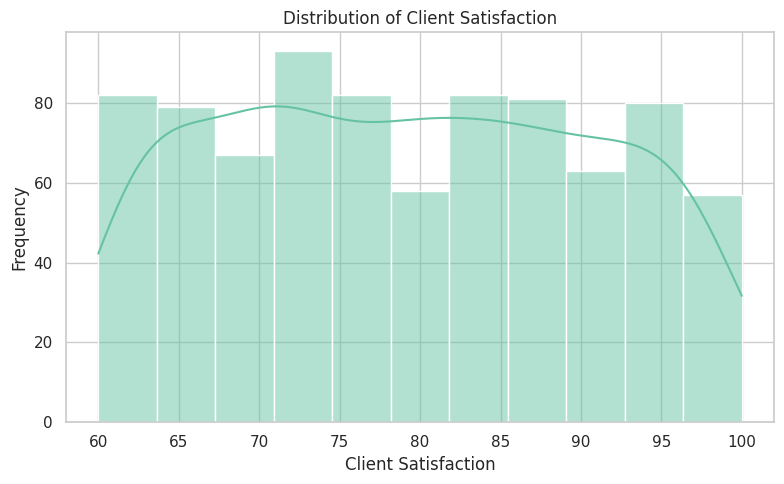

In [39]:
# Histograms
numeric_cols = ['age', 'years_of_experience', 'rating', 'hourly_rate_numeric', 'client_satisfaction']

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

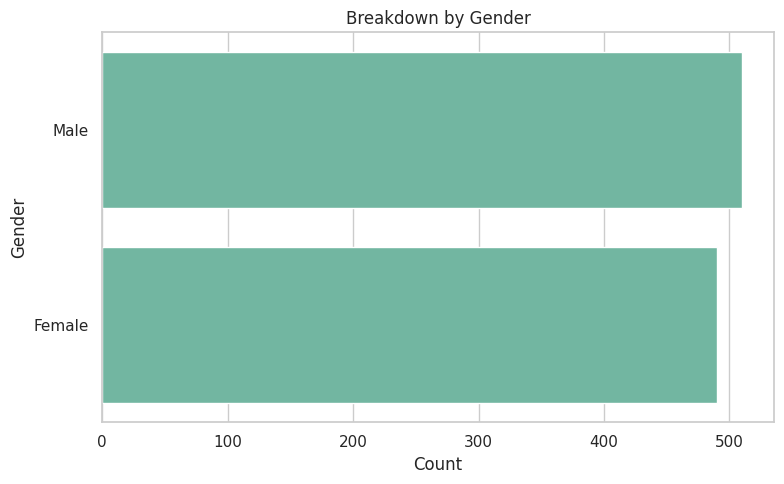

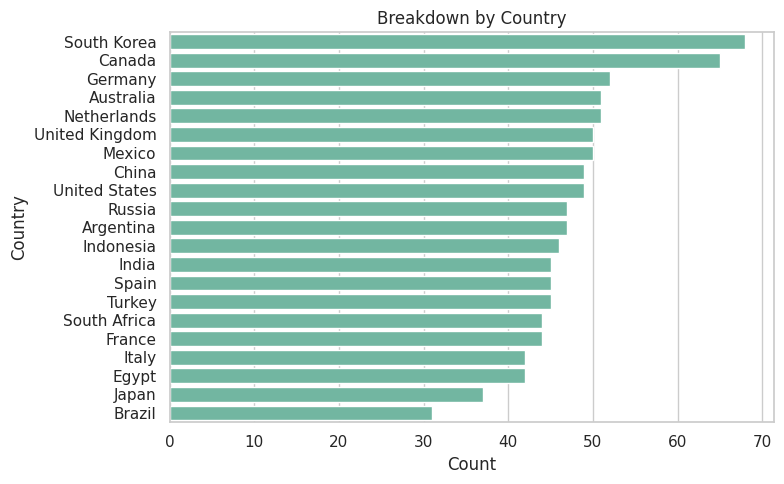

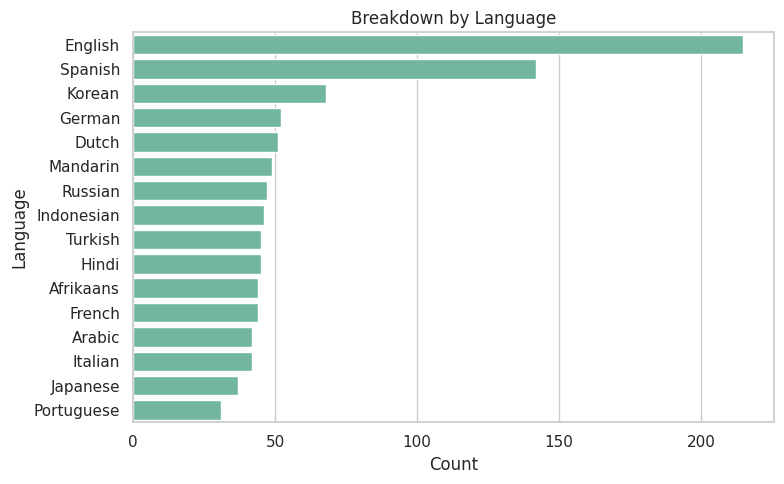

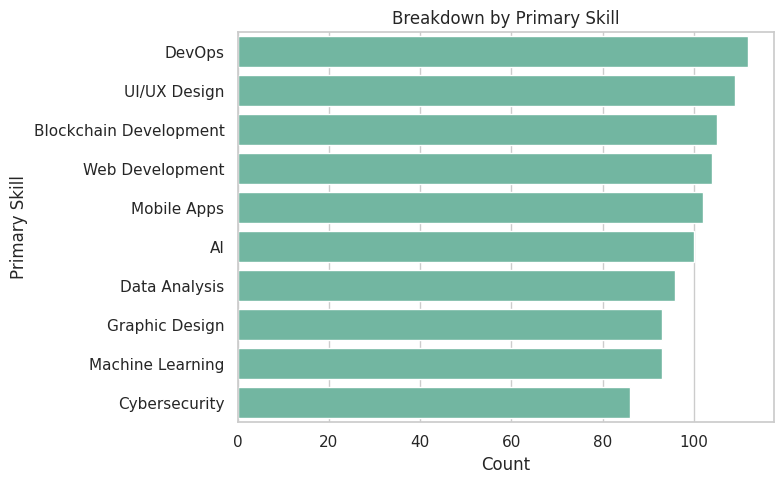

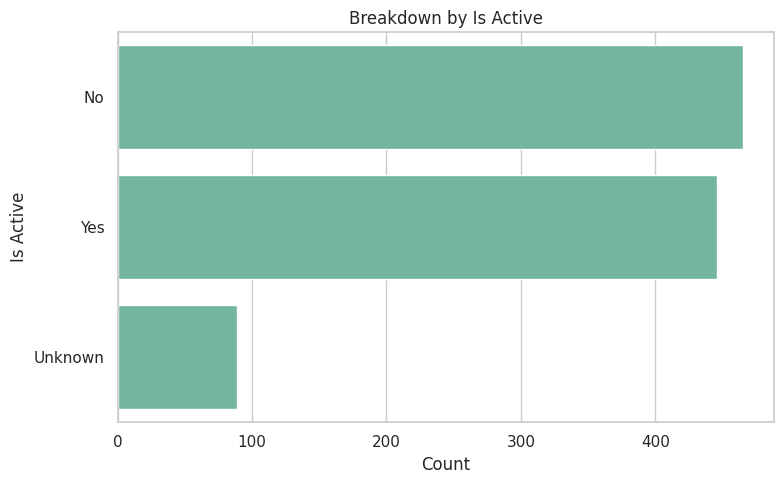

In [40]:
# Count Plots
categorical_cols = ['gender', 'country', 'language', 'primary_skill', 'is_active']

for col in categorical_cols:
    plt.figure(figsize=(8, 5))

    sns.countplot(y=col, data=df, order=df[col].value_counts().index)

    plt.title(f'Breakdown by {col.replace("_", " ").title()}')
    plt.xlabel('Count')
    plt.ylabel(col.replace("_", " ").title())

    plt.tight_layout()
    plt.show()

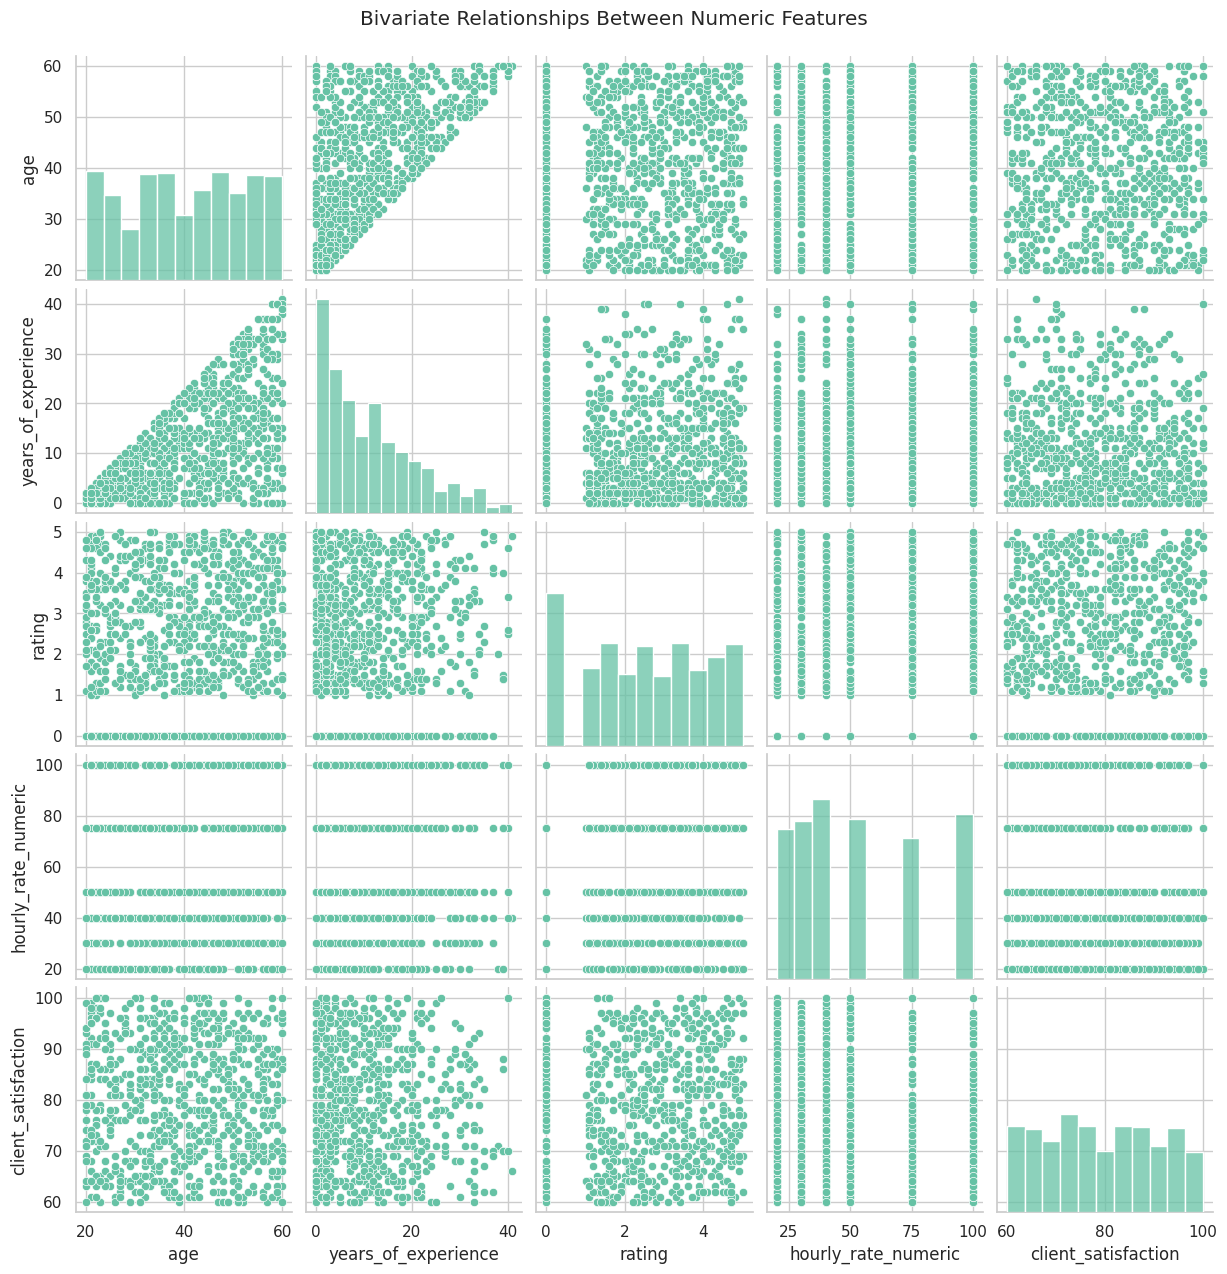

In [41]:
# Pair Plots
numeric_cols = ['age', 'years_of_experience', 'rating', 'hourly_rate_numeric', 'client_satisfaction']

sns.pairplot(data=df, vars=numeric_cols)

plt.suptitle('Bivariate Relationships Between Numeric Features', y=1.02) # Global title for the entire pair plot
plt.show()

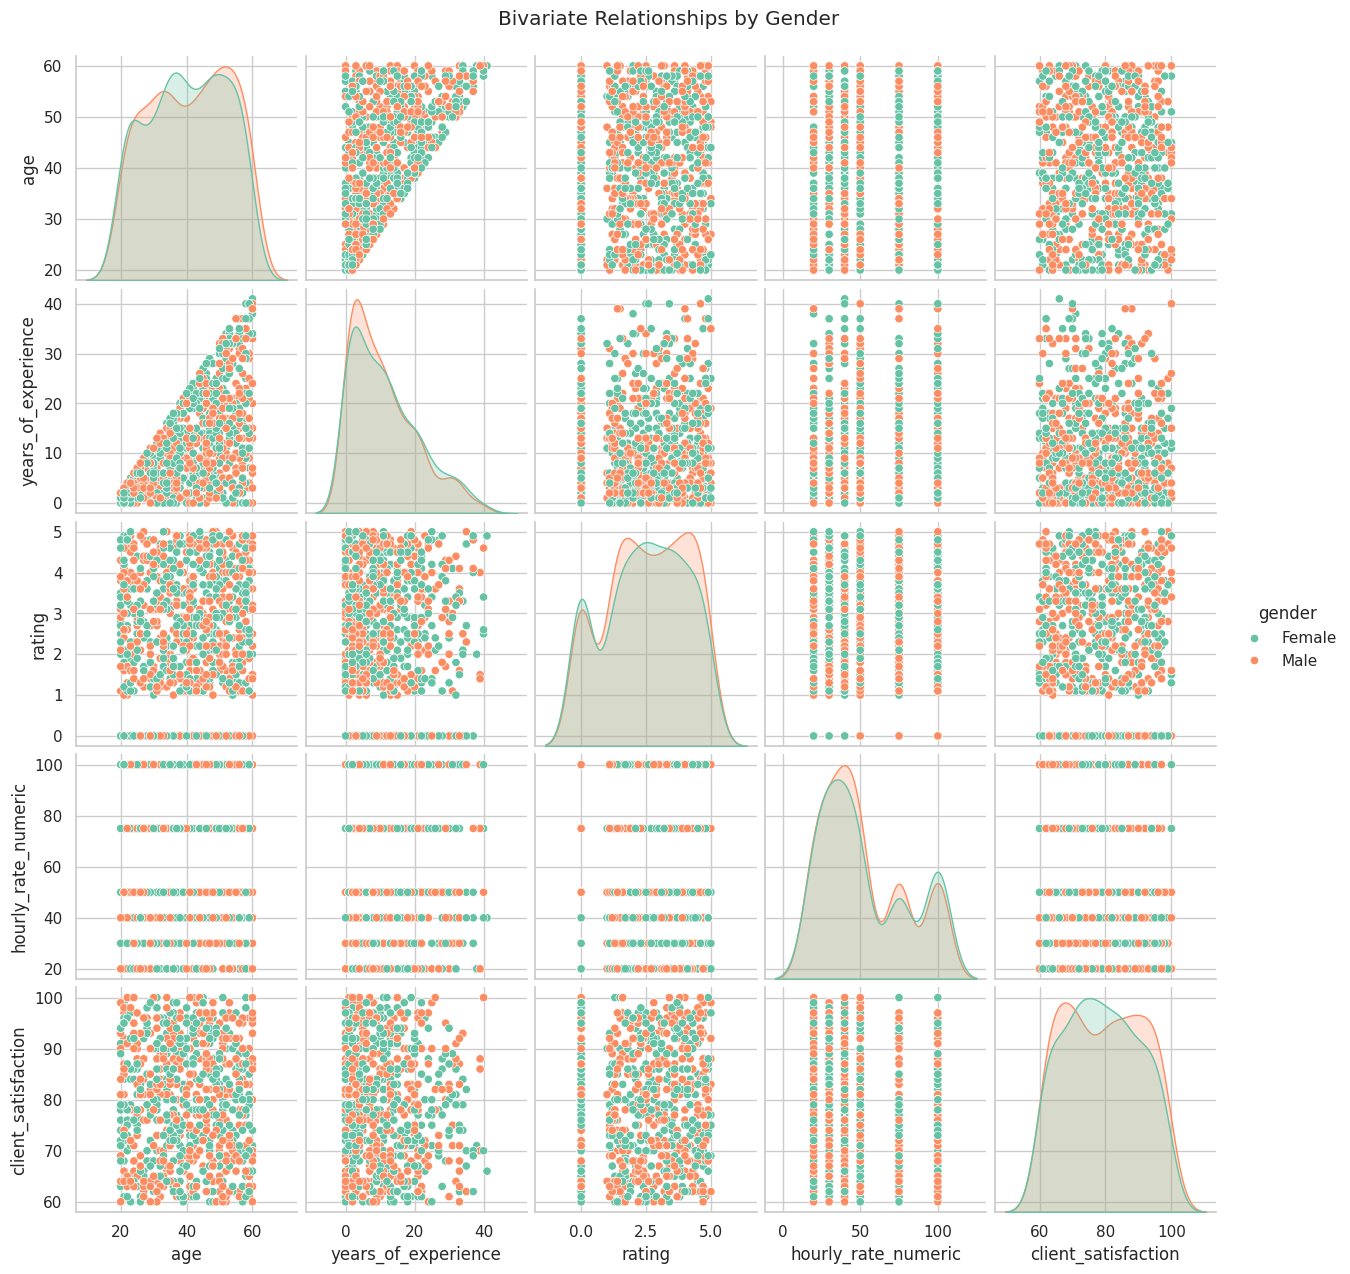

In [42]:
# Pair Plots
numeric_cols = ['age', 'years_of_experience', 'rating', 'hourly_rate_numeric', 'client_satisfaction']

sns.pairplot(data=df, vars=numeric_cols, hue='gender')
plt.suptitle('Bivariate Relationships by Gender', y=1.02)
plt.show()

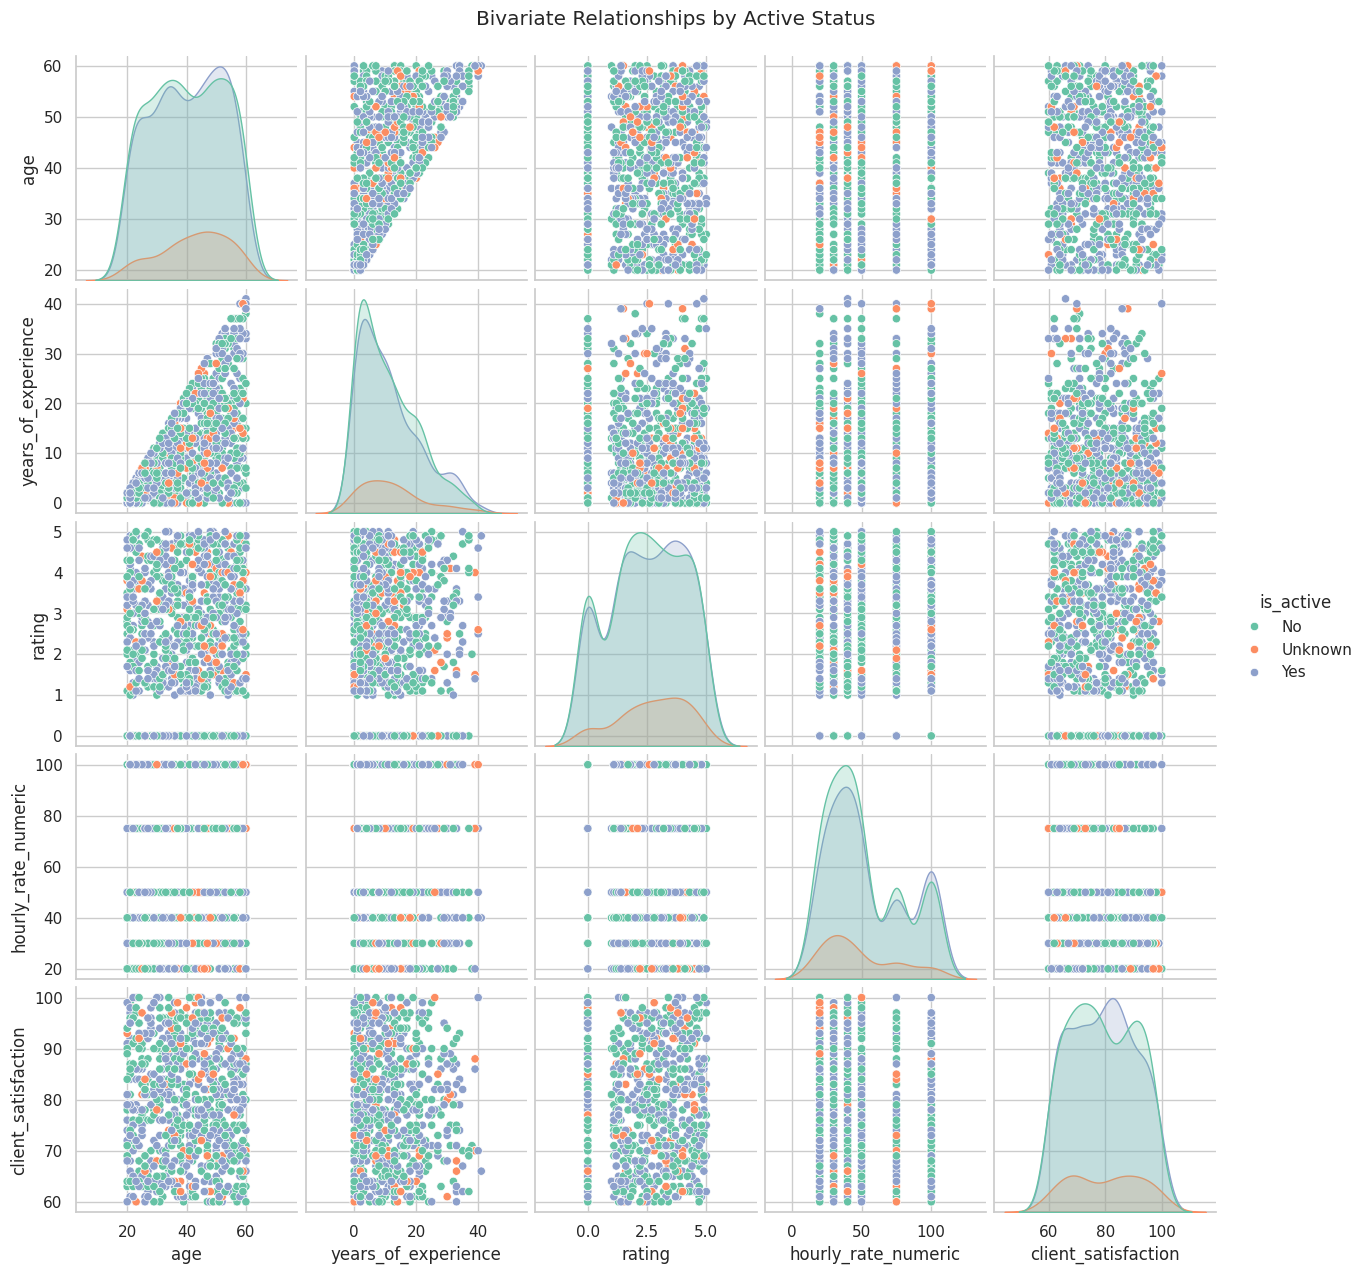

In [43]:
# Pair Plots
numeric_cols = ['age', 'years_of_experience', 'rating', 'hourly_rate_numeric', 'client_satisfaction']

sns.pairplot(data=df, vars=numeric_cols, hue='is_active')
plt.suptitle('Bivariate Relationships by Active Status', y=1.02)
plt.show()

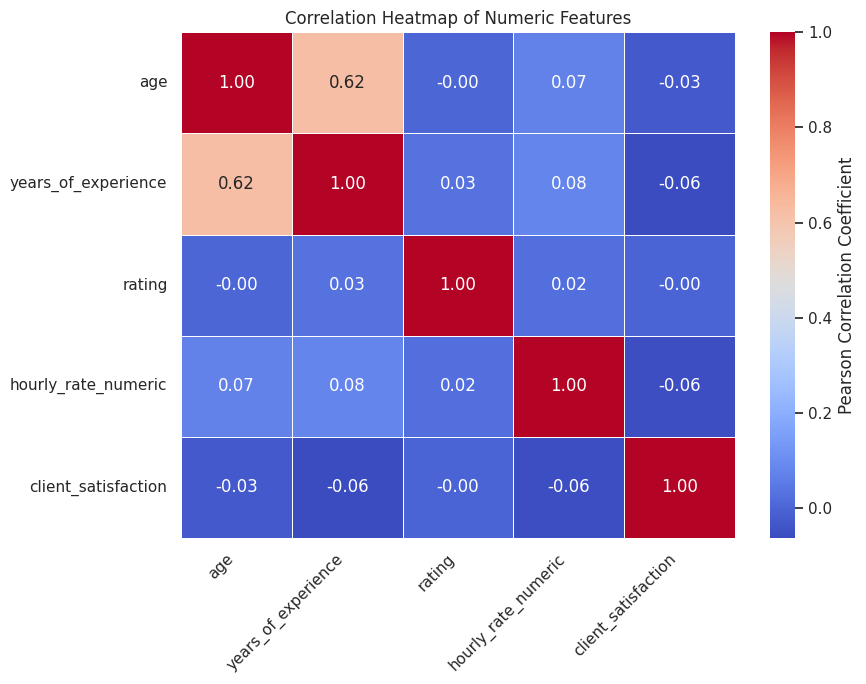

In [44]:
# Correlation Heatmap
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",      # Format numbers to two decimal places
    linewidths=.5,  # Space between cells
    cbar_kws={'label': 'Pearson Correlation Coefficient'} # Label for the color bar
)

plt.title('Correlation Heatmap of Numeric Features')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

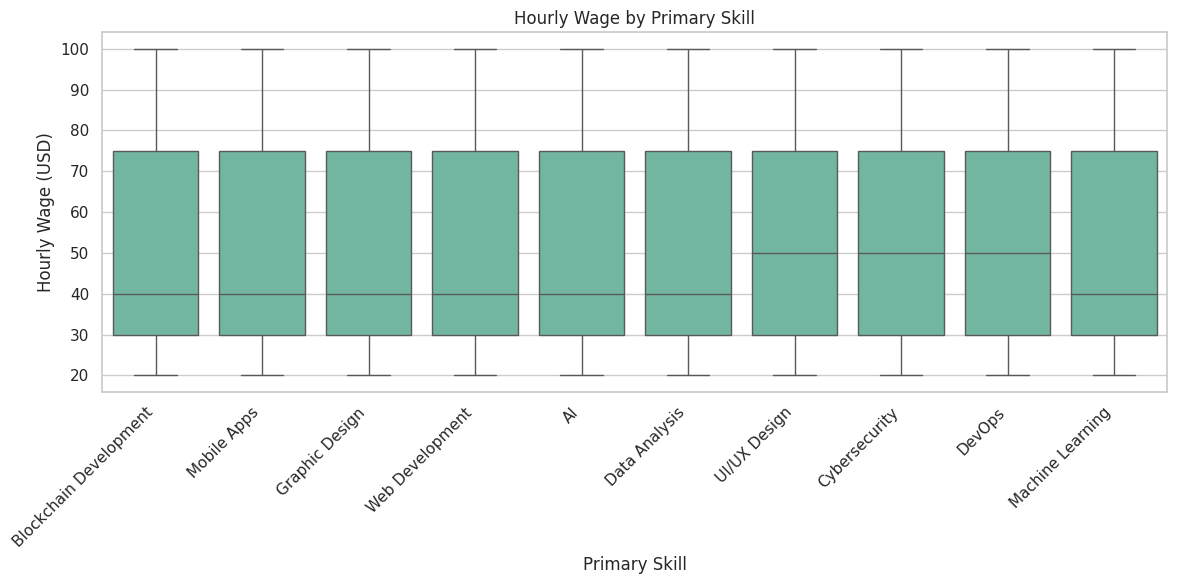

In [45]:
# Box Plot
# Box plot to inspect variations in hourly wage by primary skill
plt.figure(figsize=(12, 6))
sns.boxplot(x='primary_skill', y='hourly_rate_numeric', data=df)

plt.xticks(rotation=45, ha='right')
plt.title('Hourly Wage by Primary Skill')
plt.xlabel('Primary Skill')
plt.ylabel('Hourly Wage (USD)')
plt.tight_layout()
plt.show()

## Predictor Model

Given the rich set of features and the numeric target variable `rating`, we can build a predictor to model freelancer ratings. Here we are using a Random Forest Regressor to predict the rating based on features such as age, years of experience and hourly rate.

We evaluate model performance using the R² score. Also, we display feature importances as a bar chart to help us understand which features are the most influential in predicting freelancer ratings.

If you encounter errors regarding data conversion or feature selection during the modeling step, note that the methods used in the data cleaning cell are crucial in preemptively addressing these issues.

Random Forest Regressor R^2 Score: -0.24


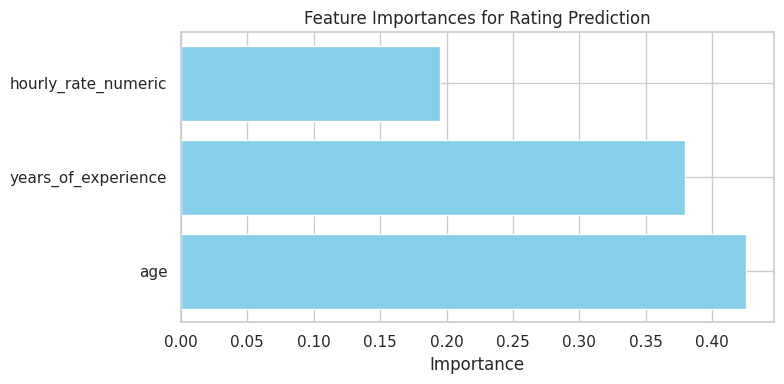

In [46]:
# Import libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Select features and target
features = ['age', 'years_of_experience', 'hourly_rate_numeric']
target = 'rating'

# Prepare data by dropping rows with missing values in selected columns
model_df = df[features + [target]].dropna()

X = model_df[features]
y = model_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using R^2 score
r2 = r2_score(y_test, y_pred)
print(f'Random Forest Regressor R^2 Score: {r2:.2f}')

# Plot Feature Importances using a horizontal bar chart
feature_importances = regressor.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances for Rating Prediction')
plt.tight_layout()
plt.show()

## Conclusion and Future Work

In this notebook we embarked on a comprehensive exploration of a global freelancers dataset. We began by cleaning the data—addressing issues such as non-numeric characters in the hourly rate—and then generated multiple visualizations to uncover relationships and distributions in the data.

The predictive modeling exercise using a Random Forest Regressor yielded an R² score that helps us assess the strength of our model in predicting freelancer ratings. Feature importance analysis provided additional insight into which factors, such as years of experience and hourly rate, exert the most influence on ratings.

For future analysis, one might consider:

- Diving deeper into categorical predictors by using techniques like one-hot encoding for skills, language, and country.
- Experimenting with alternate models and hyperparameter tuning to potentially improve predictive performance.
- Incorporating time-series data if available, for example to study freelancer activity trends over time.
